# Part 2: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

### 2.1 Genres and modularity

##### Statistics on Genres

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import collections
import json
from collections import defaultdict
import random
from fa2_modified import ForceAtlas2
from collections import Counter


Average genres per node: 3.94
------------------------------
Total distinct genres: 200
------------------------------
3. Top 15 genres and number of artists:
    1. hard rock            : 146 artists
    2. alternative rock     : 144 artists
    3. pop rock             : 106 artists
    4. rock                 : 85 artists
    5. alternative metal    : 62 artists
    6. blues rock           : 57 artists
    7. pop                  : 52 artists
    8. heavy metal          : 51 artists
    9. post-grunge          : 45 artists
   10. soft rock            : 45 artists
   11. progressive rock     : 36 artists
   12. folk rock            : 35 artists
   13. indie rock           : 35 artists
   14. new wave             : 34 artists
   15. art rock             : 32 artists
------------------------------


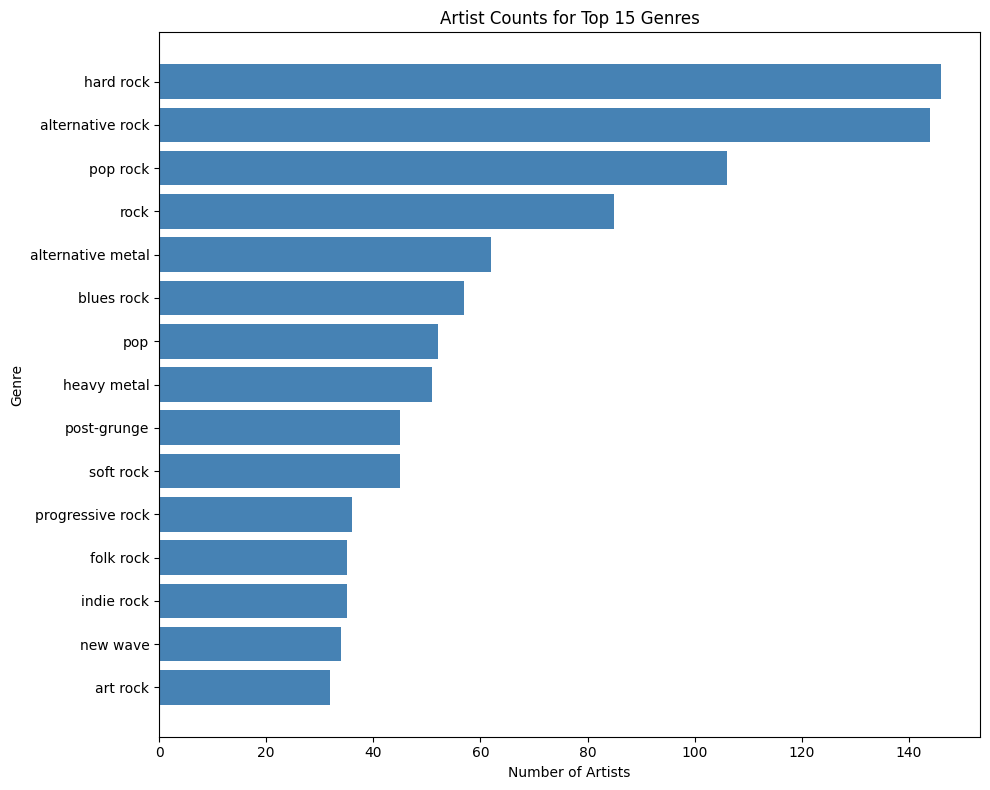

In [ ]:
# read the graph from the saved file
with open("rockstar_graph.json", "r", encoding="utf-8") as f:
    data = json.load(f)
G = nx.node_link_graph(data)

all_genres_set = set()
genre_lengths = []

for node, attributes in G.nodes(data=True):
    genres_list = attributes.get('genre', [])
    all_genres_set.update(genres_list)

    genre_lengths.append(len(genres_list))

# The average number of genres per node
total_genres_assigned = sum(genre_lengths)
total_nodes = G.number_of_nodes() 
if total_nodes > 0:
    avg_genres = total_genres_assigned / total_nodes
    print(f"Average genres per node: {avg_genres:.2f}")
else:
    print("There are no nodes in the graph.")
print("-" * 30)

# The total number of distinct genres
total_distinct_genres = len(all_genres_set)
print(f"Total distinct genres: {total_distinct_genres}")
print("-" * 30)

# A histogram showing artist counts for the top 15 genres
genre_counts = collections.Counter()
for node, attributes in G.nodes(data=True):
    genres_list = attributes.get('genre', [])
    genre_counts.update(genres_list) 
    

top_15_genres = genre_counts.most_common(15)

if not top_15_genres:
    print("There are no genres data.")
else:
    print("3. Top 15 genres and number of artists:")
    for i, (genre, count) in enumerate(top_15_genres, 1):
        print(f"   {i:2}. {genre:<20} : {count} artists")
    print("-" * 30)

    genres_to_plot = [item[0] for item in top_15_genres]
    counts_to_plot = [item[1] for item in top_15_genres]

    genres_to_plot.reverse()
    counts_to_plot.reverse()
    
    plt.figure(figsize=(10, 8)) 
    plt.barh(genres_to_plot, counts_to_plot, color='steelblue')
    plt.xlabel("Number of Artists")
    plt.ylabel("Genre")
    plt.title("Artist Counts for Top 15 Genres")
    plt.tight_layout() 
    plt.show()

* The histogram of the top 15 genres shows that **Hard Rock** (146 artists) and **Alternative Rock** (144 artists) are the most dominant categories. The number of artists in the most prevalent genres from 11th to 15th place all fell below 40, representing a decrease compared to the top ten. 
  
* Furthermore, the network exhibits significant genre complexity: the average number of genres per artist (node) is 3.94. 

##### Calculate Modularity According to Genres(two methods)

In [ ]:
def calculate_modularity(G, communities_dict):
    # Get the total number of edges in the graph
    L = G.number_of_edges()
    if L == 0:
        print("ERROR: There are no edges in the graph.")
        return 0

    # Calculate 2L for normalization (used in modularity formula)    
    two_L = 2 * L 
    
    modularity_contributions = {}
    
    for genre, nodes_in_c in communities_dict.items():
        if not nodes_in_c:
            continue

        # Create a subgraph containing only nodes in this community    
        subgraph_c = G.subgraph(nodes_in_c)
        L_c = subgraph_c.number_of_edges()
        
        k_c = sum(G.degree[node] for node in nodes_in_c if node in G)
        
        term_1 = L_c / L
        term_2_squared = (k_c / two_L) ** 2
        
        Q_c = term_1 - term_2_squared
        
        modularity_contributions[genre] = Q_c

    # Sum all community contributions to get total modularity    
    total_modularity_M = sum(modularity_contributions.values())
    return total_modularity_M

# Strategy 1: Assign each artist to a community based on their first genre
communities_first_genre = defaultdict(list)

for artist_name, attributes in G.nodes(data=True):
    genres_list = attributes.get('genre', []) 
    
    # Select the first genre from the list (if available)
    first_genre = genres_list[0] if genres_list else None 

    if first_genre: 
        communities_first_genre[first_genre].append(artist_name)

modularity_M1 = calculate_modularity(G, communities_first_genre)
print(f"The Modularity based on selecting the first genre: M1 = {modularity_M1:.4f}")


# Strategy 2: Assign each artist to a community based on a randomly selected genre
communities_random_genre = defaultdict(list)

for artist_name, attributes in G.nodes(data=True):
    genres_list = attributes.get('genre', [])
    
    # Randomly select one genre from the list (if available)
    random_genre = random.choice(genres_list) if genres_list else None

    if random_genre:
        communities_random_genre[random_genre].append(artist_name)

modularity_M_random = calculate_modularity(G, communities_random_genre)
print(f"The Modularity based on selecting genre randomly: M2 = {modularity_M_random:.4f}")


The Modularity based on selecting the first genre: M1 = 0.0915
The Modularity based on selecting genre randomly: M2 = 0.0390


* The results above show that while the first genre provides a community division (M1 = 0.0915) that is more than twice as effective as random genre selection (M2 = 0.039), both modularity scores are very low. The results indicate that both are **not good divitions of community**. The value of 0.0915 is close to 0, which means the community division is slightly better than the random network where M = 0.    
  
* Perhaps grouping multiple genres into a single broad category based on their semantic meaning before calculation would improve the results.

### 2.2 Detect the Communities

##### Detect the Communities (Louvain-Algorithm) and Compare to the Modularity of Genres

In [16]:
communities_sets = nx.community.louvain_communities(G, seed=123)
communities_list = [list(c) for c in communities_sets]

modularity = nx.community.modularity(G, communities_sets)
print(f"The Modularity based on Louvain-Algorithm: M = {modularity:.4f}")

The Modularity based on Louvain-Algorithm: M = 0.3306


* The modularity for the genre-based division is extremely low at 0.0915, while the modularity of using louvain algorithem is 0.3306, almost 4 times of the former one. The score of 0.0915, being close to 0, shows that this division is almost as arbitrary as a random partition, and fails to capture any meaningful structure in the network.  
    
* In contrast, the Louvain-Algorithm divides the community with a modularity of 0.3306, which is able to represent a significant and non-random community structure. This demonstrates that while the network does have a measurable community structure, this structure is not simply defined by one genre label. The communities are based on the network's topology, which the Louvain algorithm better identified. 

### 2.3 Calculate the Matrix D

##### Confusion Matric D Calculation

In [23]:
all_genres_counter = Counter()
for node in G.nodes():
    genres = G.nodes[node].get('genre', []) 
    all_genres_counter.update(genres)

# get Top 7 genres
top_7_genres = [genre for genre, count in all_genres_counter.most_common(7)]

print(f"Top 7 genres (G): {top_7_genres}")

# set community name
community_names = ["Comm1(Dark Blue)", "Comm2(Red)", "Comm3(Pink)", "Comm4(Light Blue)"]
# print(f"Found {len(community_names)} communities (C)")

# calculate confusion matrix
confusion_matrix_data = {}

for i, community_nodes in enumerate(communities_list):
    comm_name = community_names[i]
    
    comm_genre_counter = Counter()
    for node in community_nodes:
        genres = G.nodes[node].get('genre', [])
        comm_genre_counter.update(genres)
        
    confusion_matrix_data[comm_name] = comm_genre_counter


df_full = pd.DataFrame(confusion_matrix_data)


df_D = df_full.reindex(top_7_genres).fillna(0).astype(int)

print("\n--- confusion matrix D (7x4) ---")
print(df_D)

Top 7 genres (G): ['hard rock', 'alternative rock', 'pop rock', 'rock', 'alternative metal', 'blues rock', 'pop']

--- confusion matrix D (7x4) ---
                   Comm1(Dark Blue)  Comm2(Red)  Comm3(Pink)  \
hard rock                        56          56           22   
alternative rock                  4          48            4   
pop rock                         13          15           39   
rock                             11           1           63   
alternative metal                 1          57            0   
blues rock                       16           3           34   
pop                               2           1           42   

                   Comm4(Light Blue)  
hard rock                         12  
alternative rock                  88  
pop rock                          39  
rock                              10  
alternative metal                  4  
blues rock                         4  
pop                                7  


* The results of the confusion matrix reveals that the network is composed of four distinct communities. The use of different colours for labelling is intended to correlate with the visualisation results in the following section.  
  
* The **pink community** is the **most significant core** within the network. Judging by the results of the confusion matrix, the most prevalent genres within this community are **rock, pop, and pop rock** – indeed the most mainstream and widely listened-to music genres.  
  
* The predominant genres within the **red community** are **alternative metal, hard rock, and alternative rock**. These music styles are heavier than the mainstream music. The presence of only one node each for rock and pop within this community indicates its **distance from mainstream tastes**.  
  
* The **light blue community** is defined by an absolute dominance of **alternative rock** (88 nodes), with **pop rock** ranking second (39 nodes).    
  
* Lastly, the situation of the **dark blue community** is a little bit different. The dominant genre within the community is **hard rock**, creates an overlap with the red community, while its secondary genres, **blues rock and pop rock** connets it to the pink community.  

### 2.4 Plot the Communities

##### Plot the Communities with Different Colors

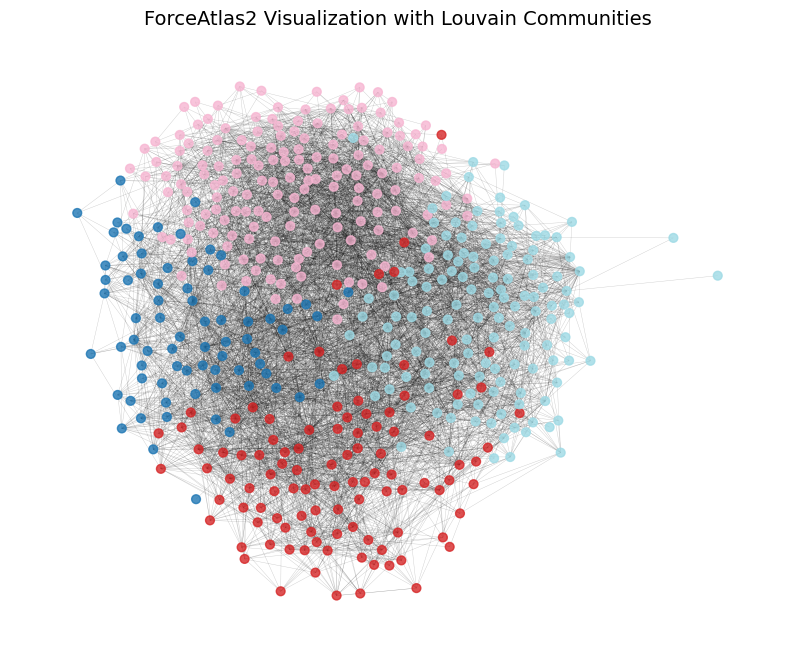

In [18]:
node_community = {}
for i, community in enumerate(communities_sets):
    for node in community:
        node_community[node] = i

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,  
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    gravity=0.5,
    verbose=False
)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=500)

colors = [node_community[n] for n in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=colors,
    cmap=plt.cm.tab20,   
    node_size=40,
    alpha=0.8
)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.3)
plt.axis("off")
plt.title("ForceAtlas2 Visualization with Louvain Communities", fontsize=14)
plt.show()

* The figure shows four communities (with four different colors) defined by Louvain-Algorithm. There are **clear boundaries between communities**, and nodes within a unified community tend to cluster together. 
  
* The fact that nodes from the red community appear more frequently in the other three communities indicates that the red community may share some characters with the other communities. It's worth noting that a light blue node appeared deep within the pink community. This could be crossover artists, connecting different communities.  
  
* However, this figure is **a hairball** with a large number of edges, making it difficult to determine the edge connections between communities from a visual representation.

##### Plot the Communities with Only Backbone-Edges

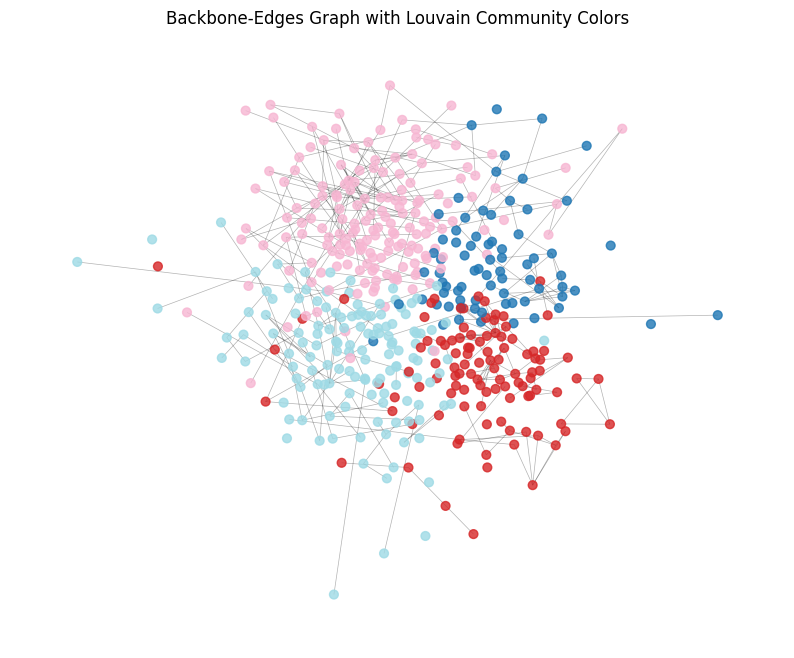

In [25]:
df = pd.read_csv("F:/DTU/02805 Social Graphs/Exercise/fliter/network1_fliter_disparity_filter.csv", sep="\t")

edges_filtered = [
    (u, v) for u, v in zip(df['src'], df['trg'])
    if u in G.nodes() and v in G.nodes()
]


H = nx.Graph()
H.add_nodes_from(G.nodes(data=True))  
H.add_edges_from(edges_filtered)

colors = [node_community.get(n, -1) for n in H.nodes()]
pos = nx.spring_layout(G, seed=123)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    H,
    pos,
    node_color=colors,
    cmap=plt.cm.tab20,
    node_size=40,
    alpha=0.8
)
nx.draw_networkx_edges(H, pos, alpha=0.3, width=0.5)
plt.axis("off")
plt.title("Backbone-Edges Graph with Louvain Community Colors")
plt.show()

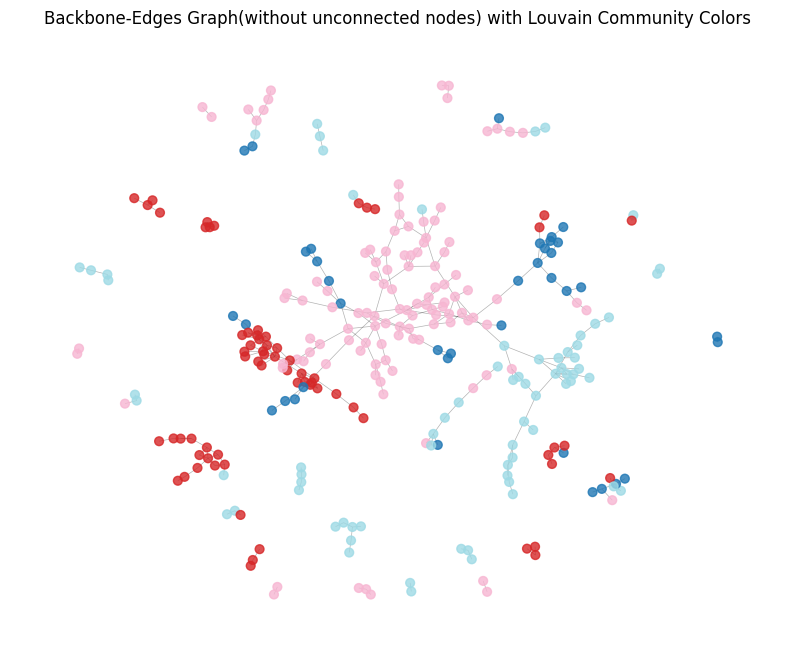

In [ ]:
G_sub = G.edge_subgraph(edges_filtered).copy()

pos = nx.spring_layout(G_sub, seed=123) 
color_map = {}

for i, comm in enumerate(communities_sets):
    for node in comm:
        color_map[node] = i
node_colors = [color_map.get(node, -1) for node in G_sub.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G_sub,
    pos,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    node_size=40,
    alpha=0.8
)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, width=0.5)
plt.axis("off")
plt.title("Backbone-Edges Graph(without unconnected nodes) with Louvain Community Colors")
plt.show()

* The first figure is the visualization with **only the backbone-edges** from the network1 backbone in week5 (edge weights calculated by edge betweenness centrality). The second figure **removes the isolated nodes** in the first figure, enabling us to better observe the structure. The advantage of retaining only the backbone edges is that it renders the image clearer and more suitable to study, as it demonstrates the most crucial connections.  
  
* The backbone visualization confirms the findings summed from the confusion matrix:

* The **pink community** truly is core of the network. The visiualization shows that the **vast majority of the backbone edges** either exist within this community or connect directly to it.  

* The **red community** appears as **a distinct cluster** with a high level of internal connectivity. There are many backbone edges connecting its own nodes, but very few connecting it to other communities.   
  
* The **light blue community** is **a hybrid community**. Its dominant genre 'alternative rock' allows it to form its own **internally connected clusters**, while its 'pop rock' overlap creates the strong **structural bridge connecting it to the pink community**.  
  
* Finally, the figure does not contain many nodes belonging to the **dark blue community**. It indicates that the dark blue community **fails to form its own robust cluster** and instead appears as **a satellite group**. Its nodes tending to connect to the other more dominant communities.  

# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

### 3.1 Explain the Concept of TF-IDF

* **TF** stands for **term frequency**. It is defined by the frequency a certain word appears in a document. A larger TF value means the word appears more frequently. However, TF alone cannot describe a word comprehensively. Words like 'a', 'an', and 'the' have a high tf, but do not have real meaning and are useless for analysis. To fix this issue, IDF is introduced.  
  
* **IDF** represents **inverse document frequency**, which measures **the uniqueness or importance** of a word. It is based on the concept that rareness is importance. It calculates $log(\frac{N}{n_t})$, where $N$ is the total number of documents in the corpus, and $n_t$ is the number of documents where the term $t$ appears. If a word is so special that it only appers in a few documents, the value of $n_t$ is small, making the $\frac{N}{n_t}$ ratio large. This results in a high IDF score. TF-IDF better measures the true importance of a word than TF. 
  
* For this task, the top words calculated only using TF were music-related, such as 'band', 'music', and 'single'. These are not stop words but are **domain-specific stop words** - they appear so frequently across all music texts that they fail to describe any specific one.  
  
* Therefore, it is necessary to employ TF-IDF to calculate the top words. It penalizes words that are too common across all documents by giving them a low IDF score, even if their TF is high.  
  
* Conversely, TF-IDF rewards words that are both frequent within a single genre (High TF) and rare across all other genres (High IDF). This method is suitable for filtering out the common noise and identifies words with genuine, unique significance, allowing us to see what really defines the textual difference between our communities and genres.

### 3.2 Calculate and Visualize TF-IDF for the Genres and Communities

##### TF-IDF for the Genres

In [1]:
import re
import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

In [4]:
with open("rockstar_graph_with_text.json", "r", encoding="utf-8") as f:
    data = json.load(f)
G = nx.node_link_graph(data)

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# set custom_stopwords according to the TF list
custom_stopwords = {
    'band', 'album', 'song', 'music', 'group', 'record', 'release', 
    'tour', 'studio', 'track', 'label', 'rock', 'formed', 'year'
}
stop_words.update(custom_stopwords)

# calculate Top 15 genres
genre_counter = Counter()
for _, data in G.nodes(data=True):
    genres = data.get("genre", [])
    genre_counter.update(genres)

top_15_genres = [g for g, _ in genre_counter.most_common(15)]
# print("Top 15 genres:", top_15_genres)

# form 15 texts accorfing to genre
genre_docs = defaultdict(list)
for _, data in G.nodes(data=True):
    text = data.get("clean_text", "")
    for g in data.get("genre", []):
        if g in top_15_genres:
            genre_docs[g].append(text)

for g in genre_docs:
    genre_docs[g] = " ".join(genre_docs[g])

# preprocess with the text +  POS fliter
processed_docs = {}

for genre, text in genre_docs.items():
    # remove all punctuation, and set to lower case
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())

    # tokenize
    tokens = word_tokenize(text)

    tokens = [w for w in tokens if w not in stop_words and w not in custom_stopwords and len(w) > 2]

    # lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # POS fliter
    pos_tags = nltk.pos_tag(tokens)
    # only n.(NN, NNS) and adj.(JJ)
    tokens = [w for w, pos in pos_tags if pos in ['NN', 'NNS', 'JJ']]

    # filter out rare words that appera less than 5 times
    counter = Counter(tokens)
    filtered_tokens = [w for w in tokens if counter[w] >= 5]

    processed_docs[genre] = filtered_tokens

# calculate TF-IDF
genres = list(processed_docs.keys())
docs = [" ".join(processed_docs[g]) for g in genres]

vectorizer = TfidfVectorizer(
    sublinear_tf=True,   # log(TF)
    min_df=1,            
    max_df=0.8,          
    stop_words='english'
)
tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=genres, columns=feature_names)

In [6]:
# List the 10 top words for each genre
top_words_dict = {}
genre_labels = list(df_tfidf.index)
for genre in genre_labels:
    top10 = df_tfidf.loc[genre].sort_values(ascending=False).head(10)
    
    top10_with_scores = [f"{word} ({score:.3f})" for word, score in top10.items()]
    top_words_dict[genre] = top10_with_scores
    
df_top_words = pd.DataFrame(top_words_dict)
df_top_words.index = [f"Rank {i+1}" for i in range(10)]

print("--- Top 10 TF-IDF Words per Genre ---")
display(df_top_words)

--- Top 10 TF-IDF Words per Genre ---


alternative metal          post-grunge           hard rock  \
Rank 1     jordison (0.053)  silverchair (0.077)      scholz (0.036)   
Rank 2     claypool (0.051)      jenkins (0.074)      nugent (0.034)   
Rank 3       crahan (0.051)       saliva (0.074)       lemmy (0.033)   
Rank 4     cavalera (0.050)          goo (0.073)     glitter (0.032)   
Rank 5      anthrax (0.050)      skillet (0.073)        ratt (0.032)   
Rank 6   belladonna (0.050)      burnley (0.071)        sixx (0.032)   
Rank 7    sepultura (0.049)        maida (0.071)   tenacious (0.032)   
Rank 8     mudvayne (0.049)   hoobastank (0.069)     bachman (0.032)   
Rank 9    columbine (0.048)      winkler (0.069)       ryder (0.032)   
Rank 10     incubus (0.048)       staind (0.069)  whitesnake (0.032)   

           alternative rock            pop rock        heavy metal  \
Rank 1    morrissey (0.036)        abba (0.046)   mustaine (0.056)   
Rank 2      sublime (0.035)     lavigne (0.042)      iommi (0.053)   
Rank 3      lavigne (0.033)  morissette (0.041)   megadeth (0.050)   
Rank 4      delonge (0.033)     glitter (0.039)        che (0.050)   
Rank 5       kiedis (0.033)       valli (0.038)   ellefson (0.050)   
Rank 6   morissette (0.033)       cuomo (0.038)        dio (0.049)   
Rank 7       hoppus (0.032)      chapin (0.038)    queensr (0.049)   
Rank 8    novoselic (0.032)       wentz (0.037)       tate (0.049)   
Rank 9   frusciante (0.032)     ulvaeus (0.037)      lemmy (0.049)   
Rank 10        inxs (0.032)       ferry (0.037)  tenacious (0.049)   

                  art rock         soft rock               rock  \
Rank 1        yule (0.076)     croce (0.075)    kravitz (0.040)   
Rank 2        cale (0.072)     fagen (0.066)    nilsson (0.038)   
Rank 3         elo (0.070)     gramm (0.061)    orbison (0.037)   
Rank 4    burchill (0.069)       rea (0.059)      mayer (0.036)   
Rank 5       ferry (0.067)     oates (0.059)     argent (0.034)   
Rank 6      mackay (0.062)     blunt (0.058)  badfinger (0.034)   
Rank 7    gouldman (0.062)    becker (0.057)   wilburys (0.034)   
Rank 8   manzanera (0.061)  gouldman (0.057)    molland (0.034)   
Rank 9     barrett (0.061)     keane (0.057)    donovan (0.033)   
Rank 10    sesnick (0.061)       csn (0.056)     polley (0.032)   

                     pop  progressive rock           folk rock  \
Rank 1      abba (0.050)       elo (0.066)   rodriguez (0.076)   
Rank 2   nilsson (0.050)  claypool (0.065)  mellencamp (0.076)   
Rank 3   orbison (0.048)   lifeson (0.058)   etheridge (0.071)   
Rank 4     mayer (0.046)   barrett (0.057)       dummy (0.071)   
Rank 5   lavigne (0.045)    downes (0.057)    everlast (0.068)   
Rank 6   donovan (0.043)     peart (0.056)     doherty (0.067)   
Rank 7     fagen (0.043)    pinder (0.056)      chapin (0.067)   
Rank 8     valli (0.042)    burdon (0.055)   lumineers (0.067)   
Rank 9   jardine (0.041)   cambria (0.054)     mumford (0.066)   
Rank 10      ono (0.041)     schon (0.054)     mcguinn (0.065)   

                 blues rock           new wave         indie rock  
Rank 1          ccr (0.067)       dury (0.097)  morrissey (0.093)  
Rank 2      caserta (0.063)       inxs (0.084)       marr (0.078)  
Rank 3      fogerty (0.062)     foxton (0.077)     koenig (0.074)  
Rank 4     clifford (0.062)   icehouse (0.077)       blur (0.073)  
Rank 5      vaughan (0.062)   strummer (0.077)     patrol (0.069)  
Rank 6    etheridge (0.061)   costello (0.072)      joyce (0.068)  
Rank 7     manzarek (0.060)  blockhead (0.070)  cranberry (0.068)  
Rank 8        betts (0.060)        ant (0.070)       cake (0.067)  
Rank 9   whitesnake (0.058)     headon (0.069)  ferdinand (0.067)  
Rank 10      joplin (0.058)      gahan (0.069)     shultz (0.065)

* The approach for handling multiple genres associated with one artist is adding the artist's text to all relevant genres. Additionally, before computation, we expended the standard stop word list to include common, music-related stop words (se.g., 'band', 'album', 'song') based on the TF list. Furthermore, nltk.pos_tag was employed for filtering, retaining only singular nouns (NN), plural nouns (NNS), and adjectives (JJ).  
  
* However, the results were **less than satisfactory**. The raw TF lists were found to be uninformative, as they were dominated by these domain-specific terms, and thus offered no real power to differentiate the genres. The TF-IDF list (shown in the table) solved this problem, but revealed another deeper one. The top terms for each genre are not stylistic descriptions (like 'lyrics' or 'soulful'), but are proper nouns - the names of artists and bands. This phenomenon is that these words appear frequently within their own genre document (high TF), but are not in others (high IDF), leading to a high rank.  
  
* We can still draw some conclusions from the table. For example, some bands are mentioned across multiple genres, such as pop rock and pop. In each case, the first term is 'elo' – Electric Light Orchestra, a British rock band.

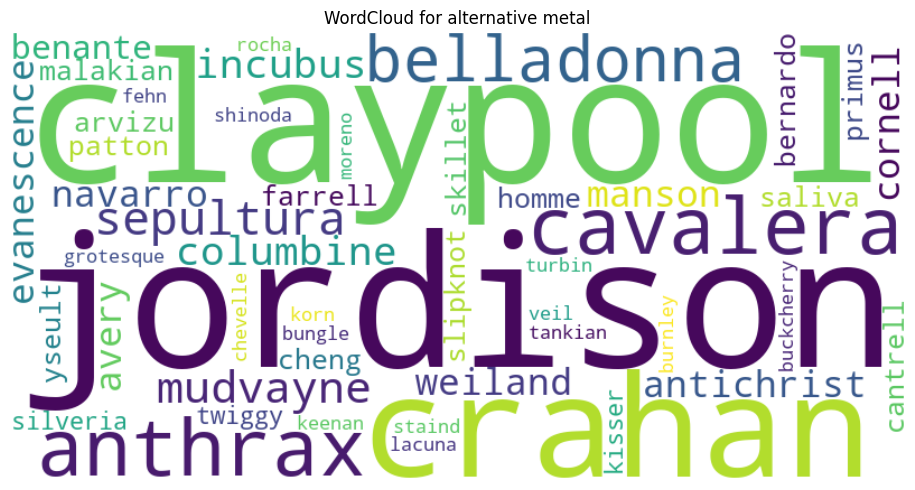

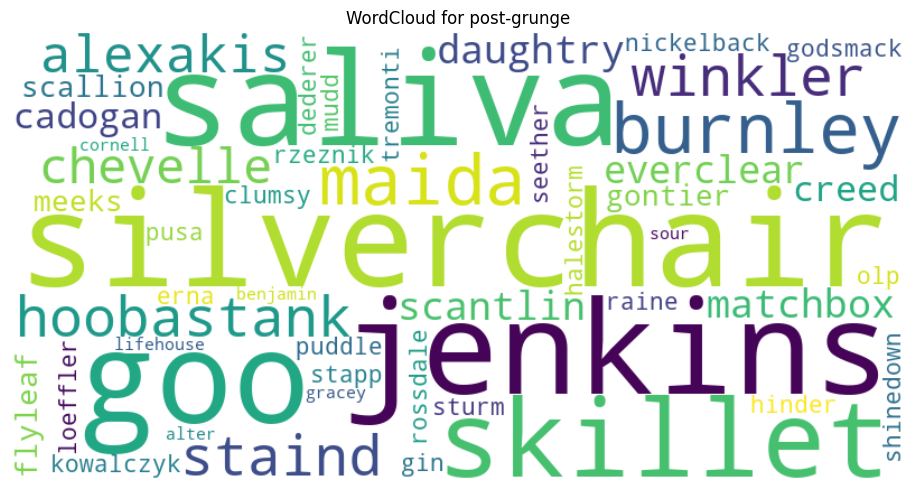

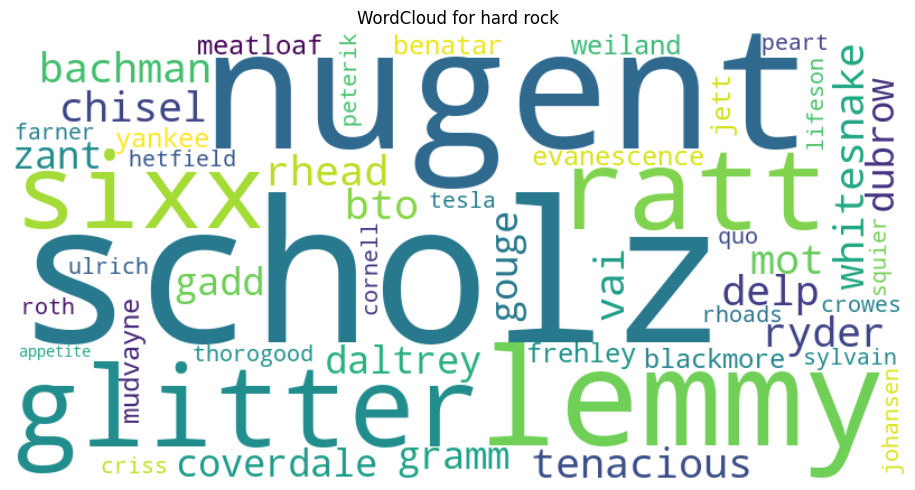

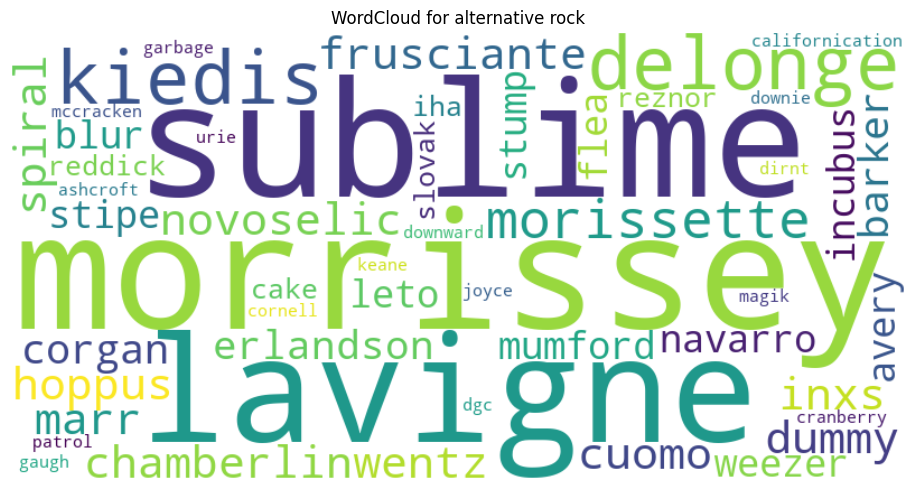

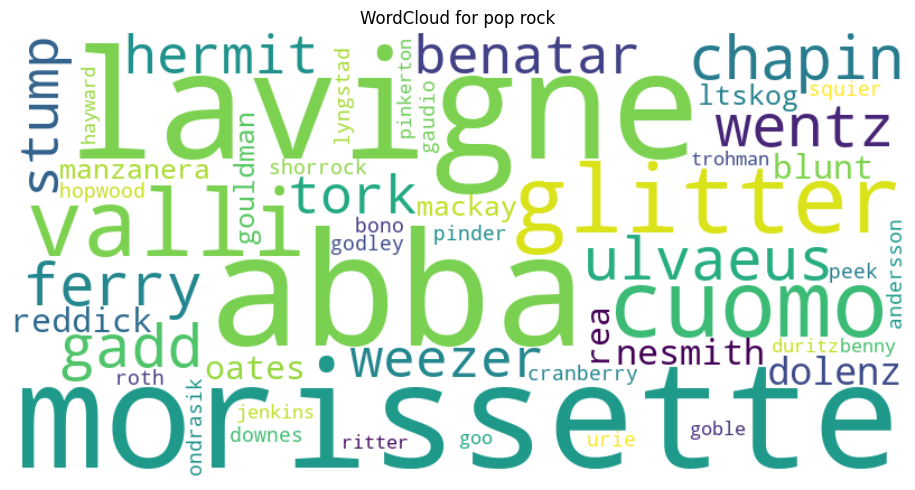

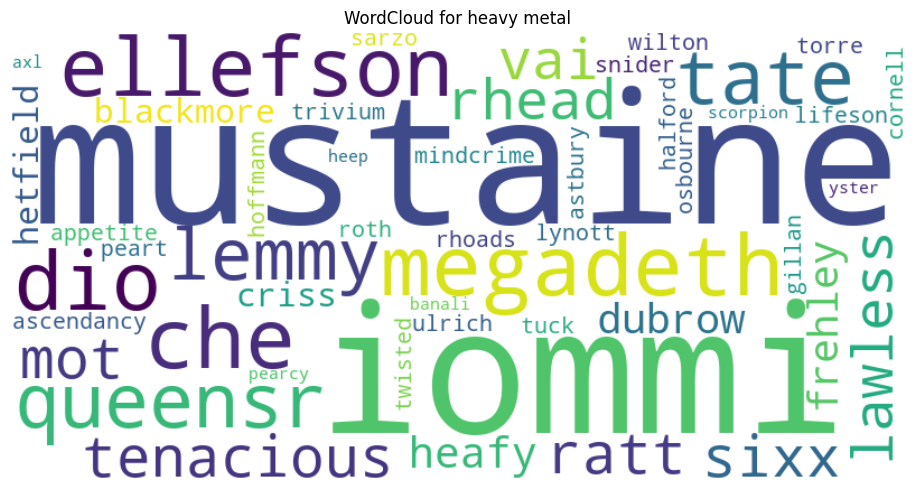

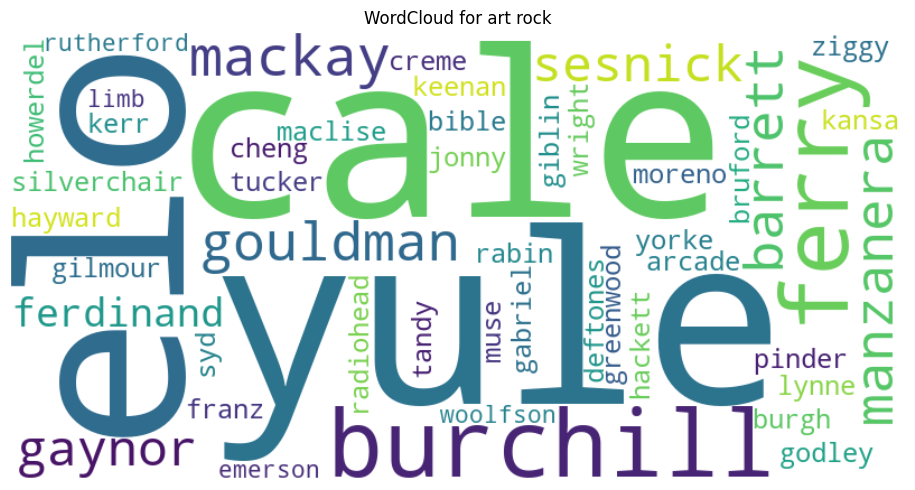

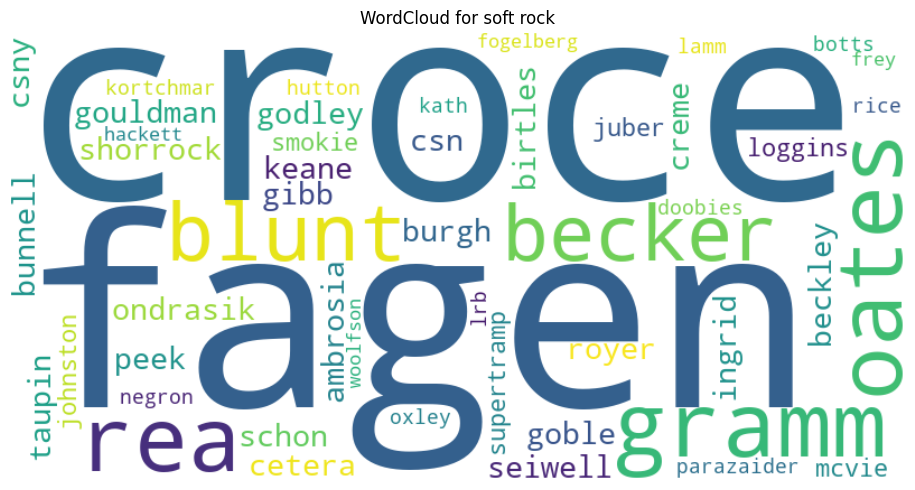

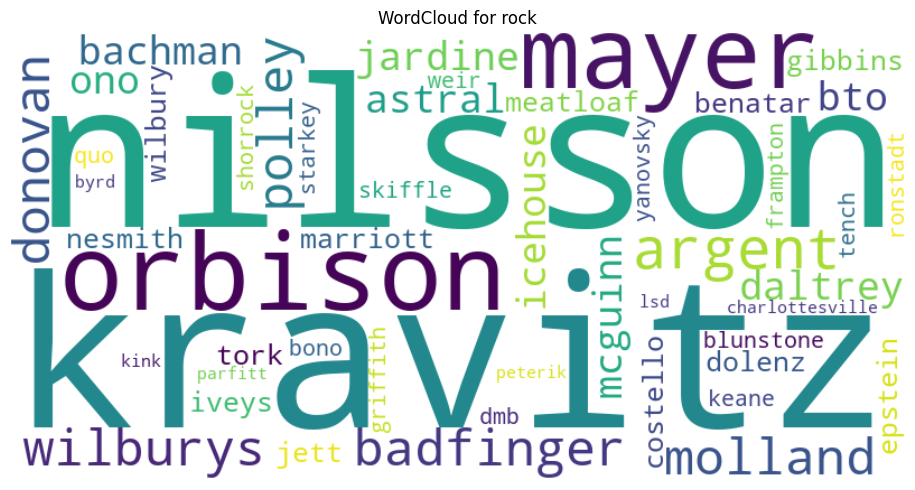

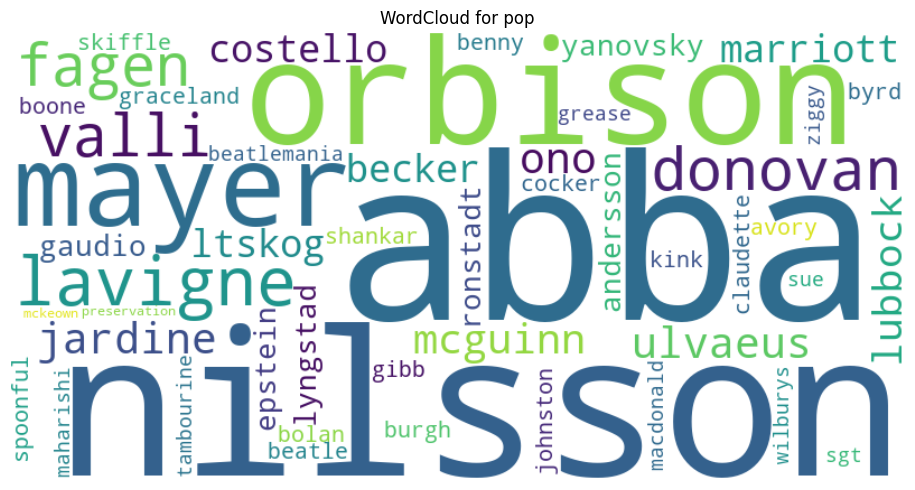

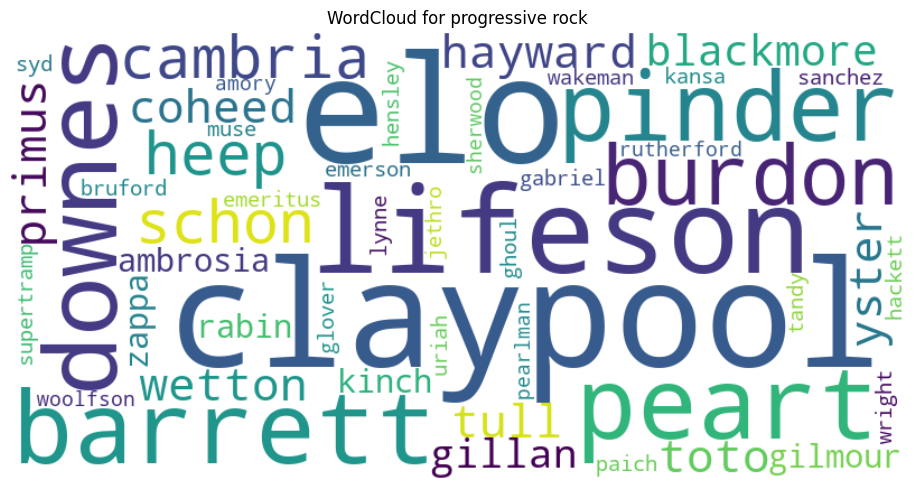

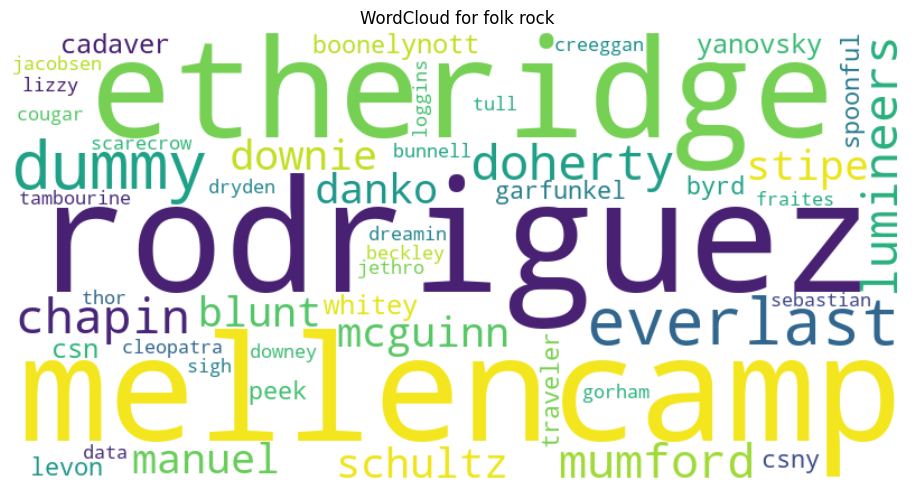

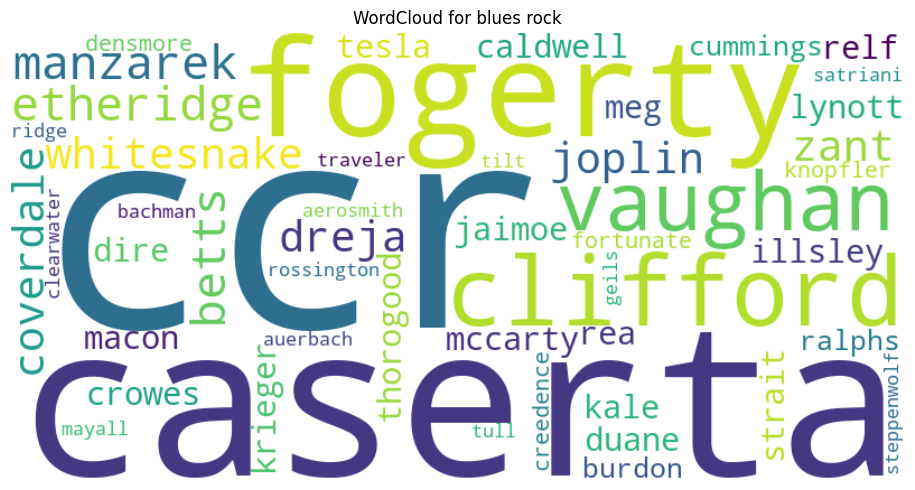

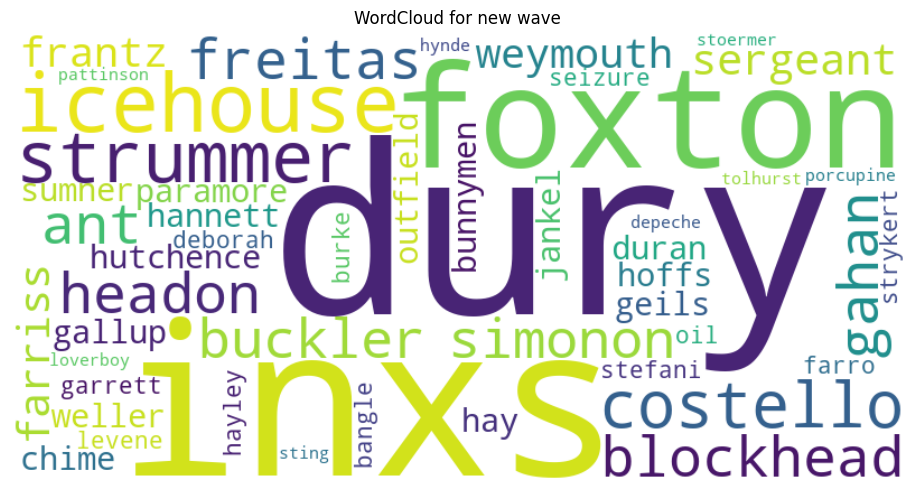

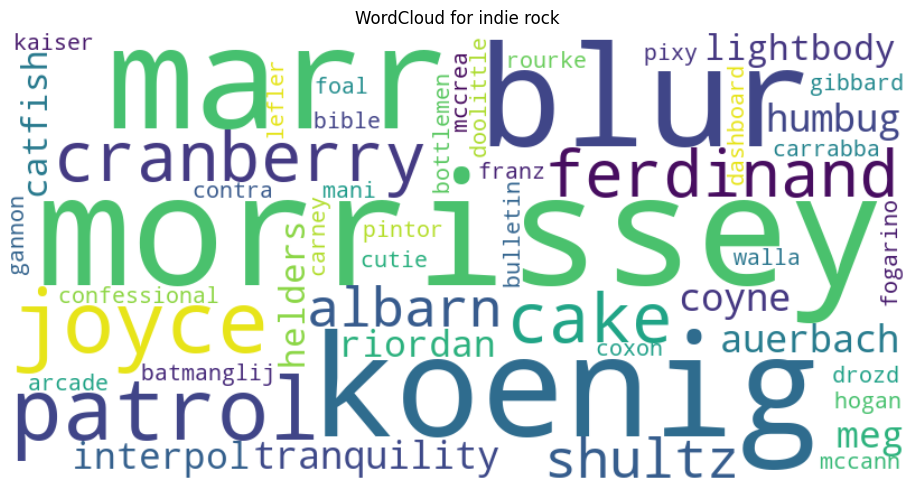

In [7]:
# Visualization with wordcloud 
records = []
for genre in genres:
    top50 = df_tfidf.loc[genre].sort_values(ascending=False).head(50)
    for word, score in top50.items():
        records.append({
            "genre": genre,
            "word": word,
            "tfidf_score": round(score, 6)
        })

df_top50 = pd.DataFrame(records)
# df_top50.to_csv("genre_top50_tfidf.csv", index=False, encoding='utf-8-sig')

for genre in df_top50["genre"].unique():
    sub = df_top50[df_top50["genre"] == genre]
    
    word_freq = dict(zip(sub["word"], sub["tfidf_score"]))
    
    # rescale the TF-IDF weights to [0, 1]
    max_val = max(word_freq.values())
    scaled_freq = {w: v / max_val for w, v in word_freq.items()}
    
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(scaled_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {genre}")
    plt.tight_layout()
    # plt.savefig(f"wordclouds/{genre}_wordcloud.png", dpi=200)
    # plt.close()
    plt.show()

* When generating word clouds from TF-IDF scores, the main issue is that TF-IDF weights are often very small (e.g., 0.002–0.05), while the wordcloud package expects relative frequencies in a range close to [0, 1] or [0, 100]. Without rescaling, most words appear very small or even invisible in the output. To address this, we **rescaled all TF-IDF values by dividing each score by the maximum TF-IDF value within the same genre**, ensuring that the most important word has a normalized weight of 1 and all other words are scaled proportionally.

* The wordclouds above show the top 50 words in each genre, with the size of the each word reflecting its TF-IDF score. We carefully looked into the first five figures. With the exception of the first one, all of the words are proper nouns, such as band names, artist names, song titles or album titles. In the first figure, wordcloud for alternative rock, only one word is not a proper noun - 'grotesque'. Grotesque means stange and unpleasent, and actually is a stylistic term used to describe alternative rock.  
  
* Therefore, we can conclude that **neither the word clouds nor the TF-IDF lists enable us to understand the genres better**. Rather than revealing a rich vocabulary of stylistic descriptors, they proved that the most 'unique' words in each genre's text are proper nouns referring to the artists and bands that define that genre.  

##### TF-IDF for the Communities

In [9]:
with open('louvain_communities.json', 'r', encoding='utf-8') as f:
    communities_sets = json.load(f)

In [29]:
community_docs = {}

for i, community_nodes in enumerate(communities_sets):
    # get all text in the same community
    texts = []
    for node in community_nodes:
        if node in G.nodes():
            text = G.nodes[node].get("clean_text", "")
            if text:
                texts.append(text)
    
    # merge into one doc per community
    community_docs[f"community_{i+1}"] = " ".join(texts)

# preprocess with the text + POS filter
processed_docs = {}

for community_name, text in community_docs.items():
    # remove all punctuation, and set to lower case
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())

    # tokenize
    tokens = word_tokenize(text)

    tokens = [w for w in tokens if w not in stop_words and w not in custom_stopwords and len(w) > 2]

    # lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # POS filter
    pos_tags = nltk.pos_tag(tokens)
    # only n.(NN, NNS) and adj.(JJ)
    tokens = [w for w, pos in pos_tags if pos in ['NN', 'NNS', 'JJ']]

    # filter out rare words that appear less than 5 times
    counter = Counter(tokens)
    filtered_tokens = [w for w in tokens if counter[w] >= 5]

    processed_docs[community_name] = filtered_tokens

# calculate TF-IDF
communities = list(processed_docs.keys())
docs = [" ".join(processed_docs[c]) for c in communities]

vectorizer = TfidfVectorizer(
    sublinear_tf=True,   # log(TF)
    min_df=1,            
    max_df=0.8,          
    stop_words='english'
)
tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=communities, columns=feature_names)

In [30]:
# List the 10 top words for each community
top_words_dict = {}
comm_labels = list(df_tfidf.index)
for comm in comm_labels:
    top10 = df_tfidf.loc[comm].sort_values(ascending=False).head(10)
    
    top10_with_scores = [f"{word} ({score:.3f})" for word, score in top10.items()]
    top_words_dict[comm] = top10_with_scores
    
df_top_words = pd.DataFrame(top_words_dict)
df_top_words.index = [f"Rank {i+1}" for i in range(10)]

print("--- Top 10 TF-IDF Words per Community ---")
display(df_top_words)

--- Top 10 TF-IDF Words per Community ---


community_1        community_2         community_3  \
Rank 1    coverdale (0.062)   slipknot (0.048)     orbison (0.034)   
Rank 2   whitesnake (0.060)   mustaine (0.048)    ronstadt (0.033)   
Rank 3         styx (0.055)    pantera (0.048)  mellencamp (0.032)   
Rank 4       lynott (0.055)     bizkit (0.047)      joplin (0.032)   
Rank 5         ratt (0.054)      iommi (0.045)       mayer (0.032)   
Rank 6         heep (0.054)       korn (0.045)     fogerty (0.031)   
Rank 7     satriani (0.053)  sepultura (0.045)        abba (0.031)   
Rank 8          quo (0.053)  rammstein (0.044)     vaughan (0.031)   
Rank 9        croce (0.053)     keenan (0.043)      henley (0.031)   
Rank 10       uriah (0.053)    weiland (0.042)     nilsson (0.031)   

               community_4  
Rank 1   morrissey (0.042)  
Rank 2     lavigne (0.039)  
Rank 3      weezer (0.037)  
Rank 4        marr (0.036)  
Rank 5     sublime (0.036)  
Rank 6        blur (0.034)  
Rank 7        inxs (0.033)  
Rank 8       dummy (0.033)  
Rank 9   tenacious (0.033)  
Rank 10    mclaren (0.032)

* The top words in the table above are still **proper nouns**: band names, artist names, song titles, and album titles. However, unlike the previous table, the same name does not appear across multiple communities. A detailed analysis of the top words in community will be conducted in conjunction with the wordclouds illustrated in the following section.

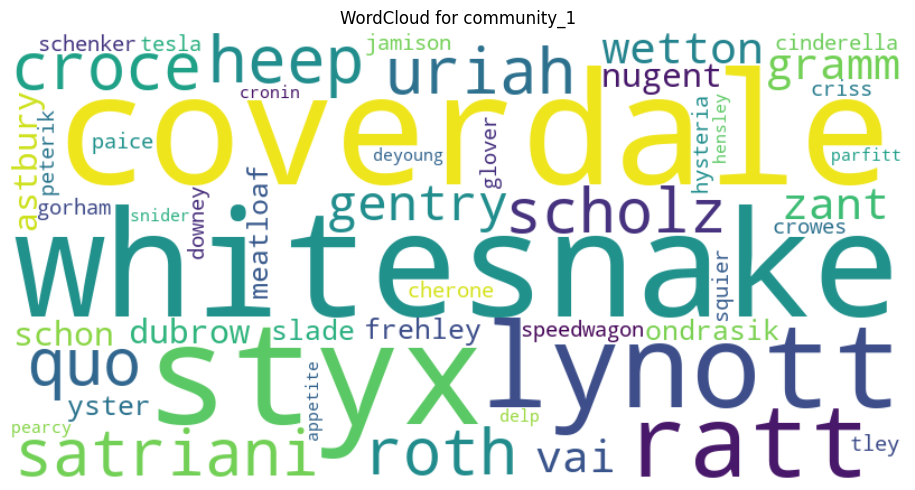

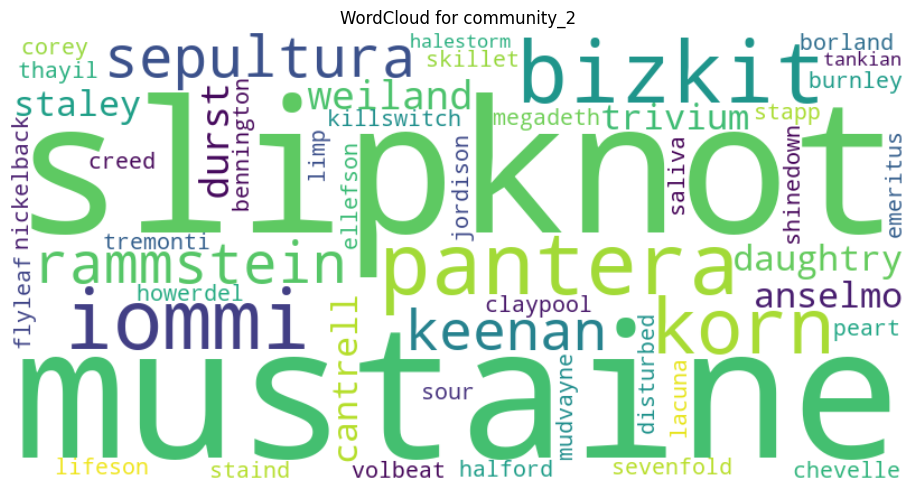

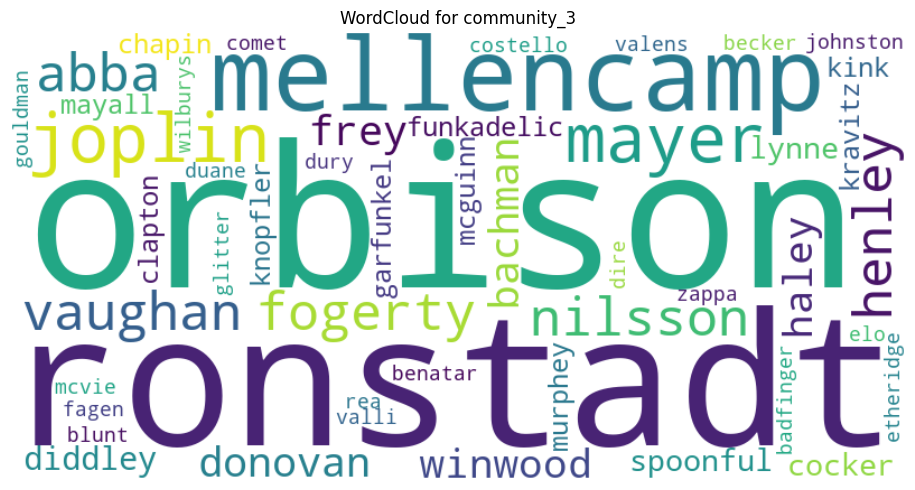

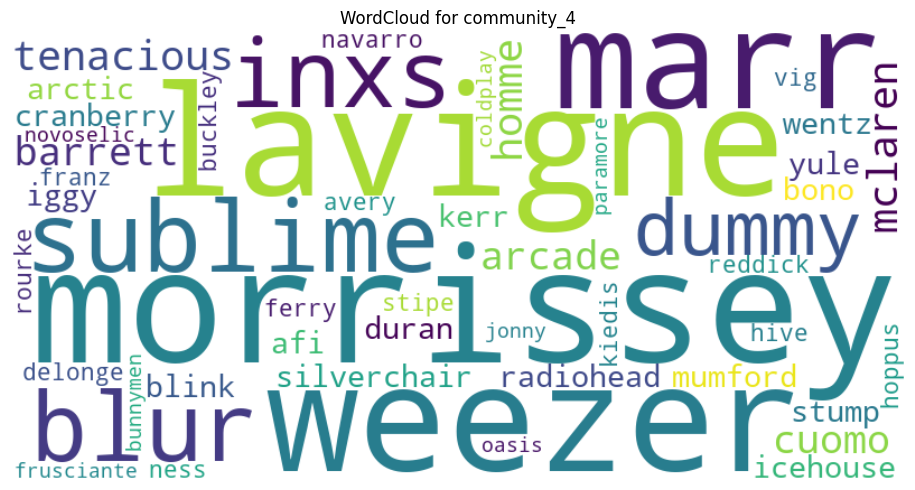

In [32]:
# Visualization with wordcloud 
records = []
for comm in comm_labels:
    top50 = df_tfidf.loc[comm].sort_values(ascending=False).head(50)
    for word, score in top50.items():
        records.append({
            "community": comm,
            "word": word,
            "tfidf_score": round(score, 6)
        })

df_top50 = pd.DataFrame(records)
# df_top50.to_csv("genre_top50_tfidf.csv", index=False, encoding='utf-8-sig')

for comm in df_top50["community"].unique():
    sub = df_top50[df_top50["community"] == comm]
    
    word_freq = dict(zip(sub["word"], sub["tfidf_score"]))
    
    # rescale the TF-IDF weights to [0, 1]
    max_val = max(word_freq.values())
    scaled_freq = {w: v / max_val for w, v in word_freq.items()}
    
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(scaled_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {comm}")
    plt.tight_layout()
    # plt.savefig(f"wordclouds/{community}_wordcloud.png", dpi=200)
    # plt.close()
    plt.show()

* The figures above show wordclouds for the top 50 words in each of the four communities, calculated using the same rescale methodology as the genre-based. Let us go through each community:  
  
* **Community 1** is the dark blue community, observed as **a satellite group with hard rock and blues rock**. The top words in the wordcloud are coverdale(David Coverdale), whitesnake, styx, and lynott(Phil Lynott). They are famous artists of exact hard rock and blues rock.
    
* **Community 2** is the red community that we found to be **a self-internal community of heavy music**. The result of wordcloud reflacts this. Its top words are slipknot, mustaine(Dave Mustaine), pantera, and bizkit(Limp Bizkit). All of them are artists in metal music, a distinct genre that is not mainstream. 
  
* **Community 3** is the pink community that we previously defined as **the main core of the network**, dominated by **rock, pop and pop rock**. Its word cloud confirms this identity. The top-ranking terms are mainstream singers and musicians like orbison(Roy Orbison), ronstadt(Linda Ronstadt), mellencamp(John Mellencamp), joplin(Janis Joplin), and mayer(John Mayer). 
  
* **Community 4** is the light blue community that dominated by **alternative rock**. Its wordcloud also illustrates this, being led by alternative and indie artists such as morrissey, lavigne (Avril Lavigne), weezer, marr(Johnny Marr), and sublime. 

* In conclusion, the results of the wordclous for each communtiy reflect the analysis from sections 2.3 and 2.4.


### 3.3 Dicusss the Difference between the Word-Clouds between Genres and Communities with Matrix D

* There are some differences between the wordclouds of genres and communities. The genre wordclouds repersent the pure text for the genre, which include the most important artists or works names, while the community wordclouds are more complex. 
  
* The reason for this can be explained by the confusion matrix D. Matrix D demonstrates that the communities are **not single-genre groups**, but, **collections of several related genres**. Therefore, the wordcloud of a community could be understood as a weighted average of the genres of its artists, and the weighting is determined by matrix D.
  
* For example, the wordcloud for community 1 (the red community) is not identical to the 'alternative metal' wordcloud. As matrix D show, community 1 also contains a significant number of 'hard rock' and 'alternative rock' artists. Its wordcloud (slipknot, mustaine, pantera) confirms this. 